# CSI4142 Project Phase 4: Data Mining
## Group 26
- Colin McFarlane 300074534 
- Will Lennox 300071951

Classification of Development Index using 20 attributes from world bank dataset 
- 1 = Developed
- 2 = Developing
- 3 = Underdeveloped


In [35]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import OneClassSVM

from imblearn.over_sampling import SMOTE

from collections import Counter

import matplotlib.pyplot as plt

global_seed = 26

np.random.seed(global_seed)

In [36]:
data = pd.read_csv('../raw_data/PHASE_4_DATA.csv')
print("Loaded data successfully")
print("Dimensionality: \n", data.shape)


Loaded data successfully
Dimensionality: 
 (144, 22)


In [37]:
training_data = data[data['split'] == 'train']

data_features = training_data.drop(['Development Index'], axis=1)
data_features = data_features.drop("split", axis=1)

data_labels = training_data['Development Index'].copy()

feature_pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', MinMaxScaler()),
])

full_pipeline = ColumnTransformer([
    ("data_features", feature_pipeline, data_features.columns),
])

data_prepared = full_pipeline.fit_transform(data_features)

print("Before oversample")
print(data_prepared.shape)
print(Counter(data_labels))


oversampler = SMOTE(random_state=global_seed)
oversampled_features, oversampled_labels = oversampler.fit_resample(data_prepared, data_labels)

print("After oversample")

print(oversampled_features.shape)
print(Counter(oversampled_labels))


Before oversample
(114, 20)
Counter({2: 52, 3: 38, 1: 24})
After oversample
(156, 20)
Counter({3: 52, 2: 52, 1: 52})


In [38]:
model_decision_tree = DecisionTreeClassifier()

model_gradient_boosting = GradientBoostingClassifier()

model_random_forest = RandomForestClassifier()

In [39]:
# Hyperparameter tuning

decision_tree_parameters = {'min_samples_split': (2, 3, 4), "max_depth": (None, 1 , 2), 'criterion':('gini', 'entropy')}

gradient_boosting_parameters = {'n_estimators': (90, 100, 110), 'max_depth': (None, 1 , 2), 'criterion':('friedman_mse', 'squared_error')}

random_forest_parameters = {'n_estimators': (90, 100, 110), 'max_depth': (None, 1 , 2), 'criterion':('gini', 'entropy')}


grid_search_decision_tree = GridSearchCV(estimator=model_decision_tree, param_grid=decision_tree_parameters)
grid_search_gradient_boosting = GridSearchCV(estimator=model_gradient_boosting, param_grid=gradient_boosting_parameters)
grid_search_random_forest = GridSearchCV(estimator=model_random_forest, param_grid=random_forest_parameters)

start_time = time.time()
grid_search_decision_tree.fit(oversampled_features, oversampled_labels)
end_time = time.time()
print("Decision Tree Fit Time: " + str(end_time-start_time))


start_time = time.time()
grid_search_gradient_boosting.fit(oversampled_features, oversampled_labels)
end_time = time.time()
print("Gradient Boosting Fit Time: " + str(end_time-start_time))

start_time = time.time()
grid_search_random_forest.fit(oversampled_features, oversampled_labels)
end_time = time.time()
print("Random Forest Fit Time: " + str(end_time-start_time))


print("\nBest Params: ")
print(grid_search_decision_tree.best_params_)
print(grid_search_gradient_boosting.best_params_)
print(grid_search_random_forest.best_params_)


print("\nBest Estimator: ")
print(grid_search_decision_tree.best_estimator_)
print(grid_search_gradient_boosting.best_estimator_)
print(grid_search_random_forest.best_estimator_)

print("\nBest Score: ")
print(grid_search_decision_tree.best_score_)
print(grid_search_gradient_boosting.best_score_)
print(grid_search_random_forest.best_score_)


Decision Tree Fit Time: 0.11400103569030762
Gradient Boosting Fit Time: 11.15217900276184
Random Forest Fit Time: 7.026682138442993

Best Params: 
{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
{'criterion': 'friedman_mse', 'max_depth': 1, 'n_estimators': 110}
{'criterion': 'gini', 'max_depth': None, 'n_estimators': 110}

Best Estimator: 
DecisionTreeClassifier()
GradientBoostingClassifier(max_depth=1, n_estimators=110)
RandomForestClassifier(n_estimators=110)

Best Score: 
0.9806451612903226
1.0
0.9808467741935484


In [40]:
testing_data = data[data['split'] == 'test']

test_data_features = testing_data.drop(['Development Index'], axis=1)
test_data_features = test_data_features.drop("split", axis=1)

test_data_labels = testing_data['Development Index'].copy()

test_data_prepared = full_pipeline.fit_transform(test_data_features)

In [41]:
dt_pred = grid_search_decision_tree.predict(test_data_prepared)
gb_pred = grid_search_gradient_boosting.predict(test_data_prepared)
rf_pred = grid_search_random_forest.predict(test_data_prepared)

print("\nDECISION TREE MODEL: ")


c_matrix = confusion_matrix(test_data_labels, dt_pred)
print(c_matrix)

report = classification_report(test_data_labels, dt_pred)
print(report)

print("\nGRADIENT BOOSTING MODEL: ")

c_matrix = confusion_matrix(test_data_labels, gb_pred)
print(c_matrix)

report = classification_report(test_data_labels, gb_pred)
print(report)

print("\nRANDOM FOREST MODEL: ")


c_matrix = confusion_matrix(test_data_labels, rf_pred)
print(c_matrix)

report = classification_report(test_data_labels, rf_pred)
print(report)



DECISION TREE MODEL: 
[[ 8  0  0]
 [ 0 12  0]
 [ 0  2  8]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         8
           2       0.86      1.00      0.92        12
           3       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.95      0.93      0.94        30
weighted avg       0.94      0.93      0.93        30


GRADIENT BOOSTING MODEL: 
[[ 8  0  0]
 [ 0 12  0]
 [ 0  1  9]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         8
           2       0.92      1.00      0.96        12
           3       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


RANDOM FOREST MODEL: 
[[ 8  0  0]
 [ 0 12  0]
 [ 0  0 10]]
              precision    recall  f1-score   support


In [42]:
column_names = data_features.columns.array
r = export_text(grid_search_decision_tree.best_estimator_ , feature_names=column_names)
print(r)

|--- Literacy rate, adult male (% of males ages 15 and above) <= 0.92
|   |--- GNI per capita, Atlas method (current US$) <= 0.05
|   |   |--- School enrollment, primary, male (% gross) <= 0.55
|   |   |   |--- People using at least basic sanitation services, rural (% of rural population) <= 0.88
|   |   |   |   |--- class: 3
|   |   |   |--- People using at least basic sanitation services, rural (% of rural population) >  0.88
|   |   |   |   |--- class: 2
|   |   |--- School enrollment, primary, male (% gross) >  0.55
|   |   |   |--- class: 2
|   |--- GNI per capita, Atlas method (current US$) >  0.05
|   |   |--- class: 2
|--- Literacy rate, adult male (% of males ages 15 and above) >  0.92
|   |--- class: 1



(30, 20)
Number of training outliers
56
Number of testing outliers
25


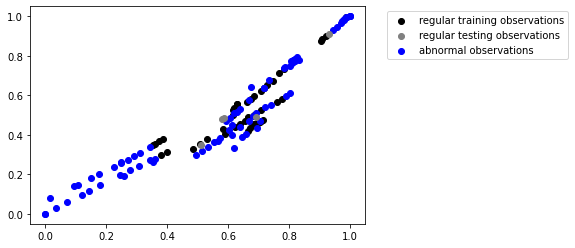

In [114]:
svm = OneClassSVM()
svm.fit(data_prepared)

svm_pred_train = svm.predict(data_prepared)
svm_pred_test = svm.predict(test_data_prepared)

print("Number of training outliers")
print(len(data_prepared[svm_pred_train == -1, 0]))
print("Number of testing outliers")
print(len(test_data_prepared[svm_pred_test == -1, 0]))

a = plt.scatter(data_prepared[svm_pred_train == 1, 0], data_prepared[svm_pred_train == 1, 1], c="black")
b = plt.scatter(data_prepared[svm_pred_train == -1, 0], data_prepared[svm_pred_train == -1, 1], c="blue")

c = plt.scatter(test_data_prepared[svm_pred_test == 1, 0], test_data_prepared[svm_pred_test == 1, 1], c="grey")
d = plt.scatter(test_data_prepared[svm_pred_test == -1, 0], test_data_prepared[svm_pred_test == -1, 1], c="blue")
plt.legend([a,c,b], ['regular training observations', 'regular testing observations', 'abnormal observations'], bbox_to_anchor=(1.05, 1))

plt.show()
